In [206]:
import pandas as pd
import numpy as np
from scipy.stats import ortho_group

np.random.seed(0)
x = ortho_group.rvs(6)

In [207]:
std_list = [1.5, 2.0, 1.5, 2.5, 1.7, 2.2]
fdf = pd.DataFrame()
for i in range(6):
    fdf[i] = np.random.normal(loc=0.0, scale=std_list[i], size=200000)

In [208]:
print(x[0])
print(x[1])

[ 0.47669462  0.15964814 -0.47766656  0.55284255 -0.13930486  0.44053222]
[ 0.10813329 -0.8838343   0.06718921  0.39309219  0.13141423 -0.1756091 ]


In [209]:
fdf["group"] = 0.9 / (1.0 + np.exp(-np.matmul(fdf.values, x[0].T) + 5.0)) +\
               0.1 / (1.0 + np.exp(-np.matmul(fdf.values, x[1].T) + 6.0))

In [210]:
fdf["prob"] = np.random.uniform(low=0.0, high=1.0, size=200000)
fdf["label"] = fdf["group"] > fdf["prob"]
fdf["label"] = fdf["label"] * 1

In [211]:
fdf.label.value_counts()

0    193807
1      6193
Name: label, dtype: int64

In [212]:
cdf = fdf.copy()
Y = cdf.label.values
X = cdf.drop(["prob", "label", "group"], axis=1).values
print(X)

[[ 0.98042789 -2.6599224  -0.83970261 -2.57846232  1.63102901  1.59680702]
 [ 1.2966543   2.77730202 -1.56281536  1.36191519  0.05851903 -1.14529369]
 [-1.11324753 -0.49798981 -1.41736499 -3.64590948 -1.74408025 -1.02271377]
 ...
 [ 0.30299166 -0.01513392 -3.76087816 -0.14516751  0.5472197  -0.88503424]
 [ 3.04884549  1.75243167  1.27937792  0.27073633  1.28851553  2.2701542 ]
 [-1.57838013 -0.60305905  0.8499289   3.59296108  0.56226344  0.36216961]]


In [213]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
torch.manual_seed(0)

In [214]:
class ImbalancedDatasetSampler(Data.sampler.Sampler):
    def __init__(self, dataset, indices=None, num_samples=None):
        self.indices = list(range(len(dataset))) if indices is None else indices
        self.num_samples = len(self.indices) if num_samples is None else num_samples
        
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
        
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)] for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)
    
    def _get_label(self, dataset, idx):
        return dataset[idx][1].item()
    
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(self.weights, self.num_samples, replacement=True))
    
    def __len__(self):
        return self.num_samples

In [215]:
class SubNet(nn.Module):
    def __init__(self):
        super(SubNet, self).__init__()
        self.fc1 = nn.Linear(1, 10)
        self.fc2 = nn.Linear(10, 2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, 1)

In [216]:
class FrontProcessing(nn.Module):
    def __init__(self):
        super(FrontProcessing, self).__init__()
        self.weight = nn.Parameter(torch.zeros(6, 2))
        self.weightT = torch.transpose(self.weight, 0, 1)
        nn.init.orthogonal_(self.weightT)
        self.weight.data.copy_(torch.transpose(self.weightT, 0, 1))
        
    def forward(self, x):
        x = torch.mm(x, self.weight)
        return x

In [217]:
class Net(nn.Module):
    def __init__(self, FrontProcessing, SubNet):
        super(Net, self).__init__()
        self.front = FrontProcessing()
        self.subnet1 = SubNet()
        self.subnet2 = SubNet()
        self.oweight = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        x = self.front(x)
        x1 = x[:, 0].view(-1, 1)
        x2 = x[:, 1].view(-1, 1)
        
        x1 = self.subnet1(x1)
        x2 = self.subnet2(x2)
        x = self.oweight * x1 + (1.0 - self.oweight) * x2
        return x[:, 1]

In [218]:
net = Net(FrontProcessing, SubNet)
net.double()
print(net)

Net(
  (front): FrontProcessing()
  (subnet1): SubNet(
    (fc1): Linear(in_features=1, out_features=10, bias=True)
    (fc2): Linear(in_features=10, out_features=2, bias=True)
  )
  (subnet2): SubNet(
    (fc1): Linear(in_features=1, out_features=10, bias=True)
    (fc2): Linear(in_features=10, out_features=2, bias=True)
  )
)


In [219]:
X_torch = torch.DoubleTensor(X)
Y_torch = torch.DoubleTensor(Y)

In [220]:
torch_data_set = Data.TensorDataset(X_torch, Y_torch)
# sampler = ImbalancedDatasetSampler(torch_data_set)
loader = Data.DataLoader(dataset=torch_data_set, batch_size=10000, shuffle=True)

In [221]:
net(X_torch)

tensor([0.4706, 0.3566, 0.3492,  ..., 0.4136, 0.3506, 0.5655],
       dtype=torch.float64, grad_fn=<SelectBackward>)

In [222]:
Y_torch

tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64)

In [223]:
list(net.parameters())

[Parameter containing:
 tensor([0.], dtype=torch.float64, requires_grad=True), Parameter containing:
 tensor([[ 0.4719,  0.0804],
         [-0.0899,  0.7272],
         [-0.6672, -0.2345],
         [ 0.1741, -0.4185],
         [-0.3321, -0.3104],
         [-0.4283,  0.3719]], dtype=torch.float64, requires_grad=True), Parameter containing:
 tensor([[-0.1612],
         [ 0.1058],
         [ 0.9055],
         [-0.9277],
         [-0.6295],
         [-0.2532],
         [-0.3898],
         [ 0.8640],
         [-0.6482],
         [-0.4603]], dtype=torch.float64, requires_grad=True), Parameter containing:
 tensor([-0.6986, -0.9366, -0.5837,  0.8596,  0.4462,  0.4847,  0.0526, -0.5127,
          0.1692, -0.9337], dtype=torch.float64, requires_grad=True), Parameter containing:
 tensor([[-0.2285, -0.1630,  0.1995,  0.1854, -0.1402, -0.0114,  0.2022,  0.3144,
           0.1255,  0.0427],
         [ 0.2120, -0.1862,  0.0589, -0.2452, -0.2192, -0.1634,  0.1431,  0.1272,
          -0.1873,  0.0955]],

In [265]:
lr = 0.1
criterion = nn.BCELoss()
optimizer = torch.optim.SGD([{'params': net.subnet1.parameters()}, 
                             {'params': net.subnet2.parameters()}], lr=lr)

In [266]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    lr: 0.1
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [ ]:
for epoch in range(600):
    for step, (X_train, Y_train) in enumerate(loader):
        optimizer.zero_grad()
        net.zero_grad()
        X_train = X_train.requires_grad_(True)
        
        prediction = net(X_train)
        loss = criterion(prediction, Y_train.double())
        
        loss.backward()
        
        weight_partial = net.front.weight.grad
        oweight_partial = net.oweight.grad
        
        with torch.no_grad():
            matA = torch.mm(weight_partial, 
                            torch.transpose(net.front.weight, 0, 1)) - torch.mm(net.front.weight, 
                                                                          torch.transpose(weight_partial, 0, 1))
            update_matrix = torch.mm(torch.inverse(torch.eye(6).double() + matA * lr / 2.0), (torch.eye(6).double() - matA * lr / 2.0))
            updated_weight = torch.mm(update_matrix, net.front.weight)
            updated_oweight = net.oweight - lr * oweight_partial
            
            net.front.weight.data.copy_(updated_weight)
            net.oweight.data.copy_(updated_oweight)
            net.oweight.clamp_(0, 1)
        
        optimizer.step()
        
    with torch.no_grad():
        loss_all = criterion(net(X_torch), Y_torch.double())
        print("Epoch: ", epoch, "| loss: ", loss_all.data.numpy())
        print(net.front.weight)
        print(net.oweight)
        print("##########################")

Epoch:  0 | loss:  0.09846804762434078
Parameter containing:
tensor([[ 0.4688, -0.1700],
        [ 0.1619,  0.8120],
        [-0.4934, -0.2367],
        [ 0.5393, -0.4604],
        [-0.1496, -0.1697],
        [ 0.4442,  0.1223]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([0.8455], dtype=torch.float64, requires_grad=True)
##########################
Epoch:  1 | loss:  0.09846489946310931
Parameter containing:
tensor([[ 0.4683, -0.1693],
        [ 0.1612,  0.8122],
        [-0.4930, -0.2374],
        [ 0.5409, -0.4597],
        [-0.1497, -0.1699],
        [ 0.4435,  0.1230]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([0.8450], dtype=torch.float64, requires_grad=True)
##########################
Epoch:  2 | loss:  0.09846340850763884
Parameter containing:
tensor([[ 0.4679, -0.1687],
        [ 0.1606,  0.8123],
        [-0.4927, -0.2379],
        [ 0.5421, -0.4592],
        [-0.1498, -0.1700],
        [ 0.4430,  0.1235]], dtype=torch.fl

Epoch:  22 | loss:  0.09846132630602275
Parameter containing:
tensor([[ 0.4653, -0.1668],
        [ 0.1582,  0.8129],
        [-0.4912, -0.2401],
        [ 0.5468, -0.4573],
        [-0.1507, -0.1704],
        [ 0.4422,  0.1253]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([0.8442], dtype=torch.float64, requires_grad=True)
##########################
Epoch:  23 | loss:  0.09846080228350852
Parameter containing:
tensor([[ 0.4655, -0.1668],
        [ 0.1582,  0.8128],
        [-0.4913, -0.2400],
        [ 0.5466, -0.4573],
        [-0.1507, -0.1704],
        [ 0.4422,  0.1253]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([0.8439], dtype=torch.float64, requires_grad=True)
##########################
Epoch:  24 | loss:  0.09846080313316422
Parameter containing:
tensor([[ 0.4655, -0.1669],
        [ 0.1582,  0.8128],
        [-0.4913, -0.2400],
        [ 0.5464, -0.4574],
        [-0.1508, -0.1704],
        [ 0.4423,  0.1252]], dtype=torch

Epoch:  44 | loss:  0.09846082110483723
Parameter containing:
tensor([[ 0.4653, -0.1668],
        [ 0.1582,  0.8128],
        [-0.4911, -0.2402],
        [ 0.5467, -0.4574],
        [-0.1508, -0.1703],
        [ 0.4424,  0.1253]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([0.8445], dtype=torch.float64, requires_grad=True)
##########################
Epoch:  45 | loss:  0.09846070628420657
Parameter containing:
tensor([[ 0.4653, -0.1668],
        [ 0.1582,  0.8128],
        [-0.4911, -0.2401],
        [ 0.5466, -0.4574],
        [-0.1508, -0.1703],
        [ 0.4425,  0.1253]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([0.8444], dtype=torch.float64, requires_grad=True)
##########################
Epoch:  46 | loss:  0.09846068527494058
Parameter containing:
tensor([[ 0.4653, -0.1668],
        [ 0.1581,  0.8128],
        [-0.4911, -0.2402],
        [ 0.5466, -0.4574],
        [-0.1509, -0.1703],
        [ 0.4424,  0.1253]], dtype=torch

In [241]:
x[0]

array([ 0.47669462,  0.15964814, -0.47766656,  0.55284255, -0.13930486,
        0.44053222])

In [242]:
x[1]

array([ 0.10813329, -0.8838343 ,  0.06718921,  0.39309219,  0.13141423,
       -0.1756091 ])

In [243]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([0.8297], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[ 0.4650, -0.1690],
        [ 0.1581,  0.8144],
        [-0.4924, -0.2387],
        [ 0.5453, -0.4546],
        [-0.1475, -0.1710],
        [ 0.4441,  0.1238]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[-0.1522],
        [ 0.1058],
        [ 0.7251],
        [-0.2440],
        [-0.6087],
        [-0.1706],
        [-0.3767],
        [ 0.6839],
        [-0.5567],
        [-0.4776]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([-0.7005, -0.9366, -0.7670,  1.5191,  0.6499,  1.0968,  0.1035, -0.6464,
         0.4757, -0.9273], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[-0.2282, -0.1630, -0.1215,  0.4332,  0.1388,  0.3737,  0.1821, -0.0019,
          0.2313,  0.0155],
        [ 0.2117, -0.1862,  0.3799, -0.4929, -0.4983, -0.5485,  0.1632,  0.4434,
         -0.2932,  0.1227]], dtype=torch.float64, re

In [244]:
# out = net(X_torch)
# _, prediction = torch.max(out.data, 1)
# print('accuracy:%.3f %%' % (100 * torch.sum(Y_torch.long()==prediction) / 200000))

In [245]:
x_result_1 = net.front(X_torch)[:, 0].view(-1, 1).data.numpy()

In [246]:
y_result_1 = net.subnet1(net.front(X_torch)[:, 0].view(-1, 1))[:, 1].data.numpy()

In [247]:
x_true_1 = np.arange(-10, 10, 0.1)

In [248]:
y_true_1 = 1.0 / (1.0 + np.exp(-x_true_1 + 5))

In [249]:
x_result_2 = net.front(X_torch)[:, 1].view(-1, 1).data.numpy()

In [250]:
y_result_2 = net.subnet2(net.front(X_torch)[:, 1].view(-1, 1))[:, 1].data.numpy()

In [254]:
x_true_2 = np.arange(-10, 10, 0.1)

In [255]:
y_true_2 = 1.0 / (1.0 + np.exp(-x_true_2 + 6))

In [251]:
# y_result

In [252]:
# from sklearn.linear_model import LinearRegression

# reg = LinearRegression()
# reg.fit(x_result, y_result)

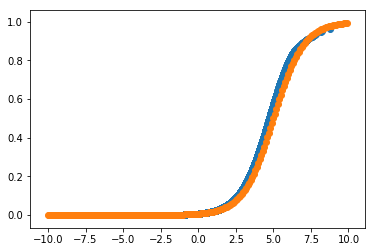

In [253]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(x_result_1.reshape(-1, 1), y_result_1)
ax.scatter(x_true_1, y_true_1)
# ax.plot(x_result.reshape(-1, 1), reg.predict(x_result))
plt.show()

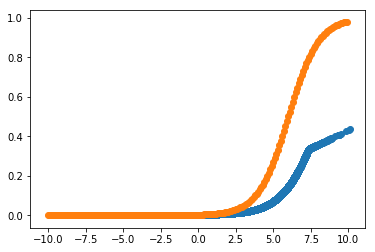

In [257]:
fig, ax = plt.subplots()
ax.scatter((1.0 - x_result_2).reshape(-1, 1), y_result_2)
ax.scatter(x_true_2, y_true_2)
# ax.plot(x_result.reshape(-1, 1), reg.predict(x_result))
plt.show()

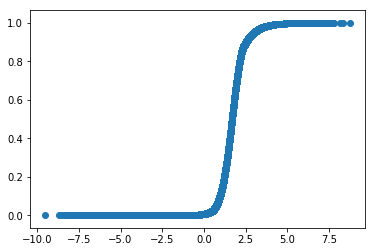

In [68]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter((x_result_1).reshape(-1, 1), y_result_1)
# ax.plot(x_result.reshape(-1, 1), reg.predict(x_result))
plt.show()